## Daisychaining Methods for Real-World Image Restoration
Thus far in these workshops we have been exploring how to use particular methods to solve a fixed task, whether that task is image denoising, deblurring, or inpainting. In this notebook, we're going to explore how to solve an image restoration problem using any methods we can think of.

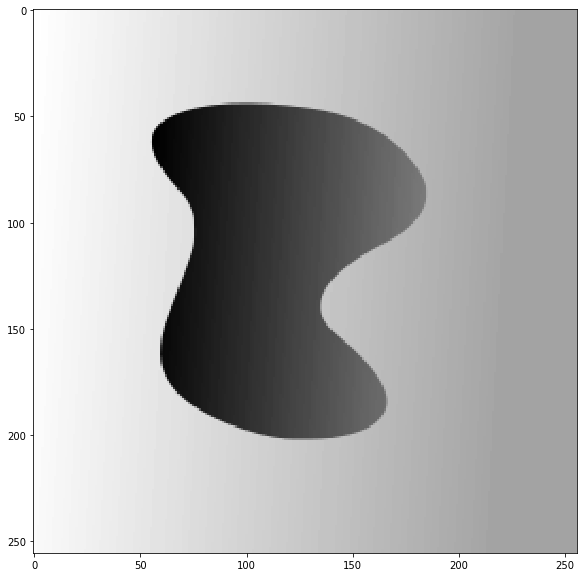

In [1]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

cwd = os.getcwd()
image_folder = cwd + "/images/"

example_image_path = image_folder + "blob.png"
test_image = imageio.imread(example_image_path, pilmode='L')

# example_image_path = image_folder + "cameraman.jpg"
# test_image = imageio.imread(example_image_path)
fig = plt.figure()
plt.imshow(test_image, cmap='gray')
plt.show()

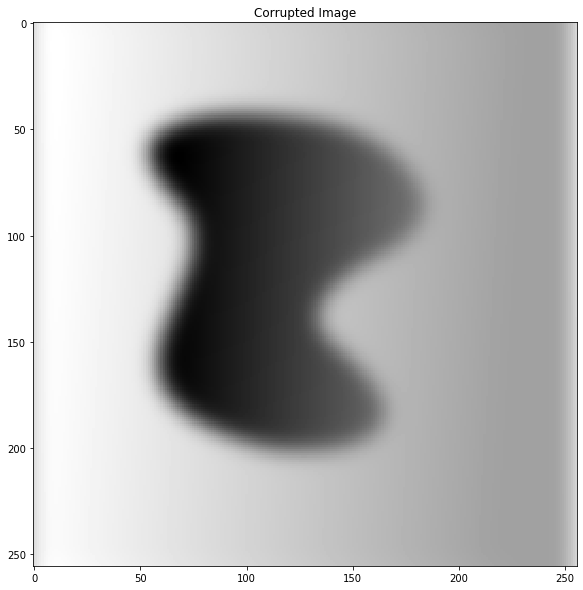

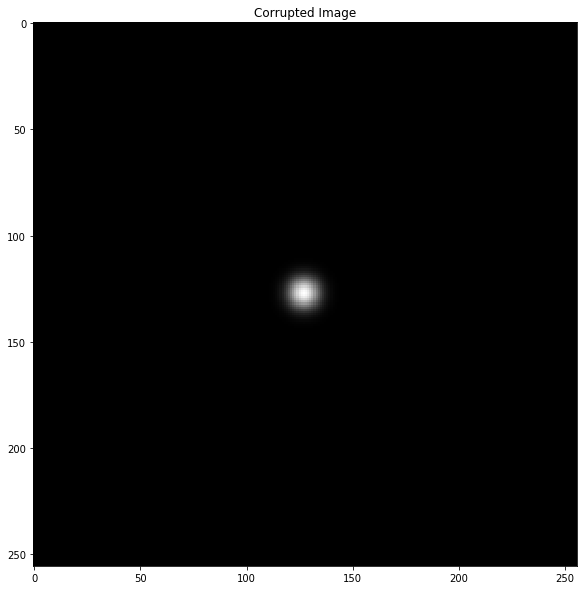

In [29]:
import corruption_models
from scipy.signal import convolve
def gaussian_filter_coeffs(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / np.sum(g[:])

def uniform_filter_coeffs(size, width):
    g = np.zeros((size,size))
    lower_bound = int(size//2 - width//2)
    upper_bound = int(size//2 + width//2)
    g[lower_bound:upper_bound, lower_bound:upper_bound] = 1
    return g / np.sum(g[:])

image_dimensions = np.shape(test_image)[0]
kernel_sigma = 5
noise_sigma = 0.000001
# blur_kernel = uniform_filter_coeffs(image_dimensions, kernel_sigma)
blur_kernel = gaussian_filter_coeffs(image_dimensions, kernel_sigma)

# pixel_deletion_mask = corruption_models.get_inpainting_map(np.shape(test_image), p=0.95)
# corrupted_image = corruption_models.apply_inpainting_map(test_image, pixel_deletion_mask)

corrupted_image = corruption_models.blur_and_add_noise(test_image, blur_kernel, noise_sigma)

fig = plt.figure()
plt.imshow(corrupted_image, cmap='gray'); plt.title("Corrupted Image")
plt.show()
fig = plt.figure()
plt.imshow(blur_kernel, cmap='gray'); plt.title("Corrupted Image")
plt.show()

In [41]:
import iterative_methods
import wavelet_denoising
from skimage import restoration

def wav_denoise(input_img, threshold):
    restored_image = wavelet_denoising.cycle_spin_denoise(input_img, threshold)
    return restored_image

threshold = 1.0
tv_maxiters=50
is_multichannel=False
tv_lambda=100
projector = lambda x: wavelet_denoising.cycle_spin_denoise(x, threshold)
# projector = lambda x: restoration.denoise_tv_chambolle(x, weight=tv_lambda, n_iter_max=tv_maxiters, multichannel=is_multichannel)


# regularization_lambda = 0.01 # Regularization strength - this is actually half the lambda value used in the optimization
# maxiters = 100 # Number of optimization iterations to go through before stopping.
# multichannel = False # Change to True if you want to use for color images
# projector = lambda x: restoration.denoise_tv_chambolle(x, weight=regularization_lambda, n_iter_max=maxiters, multichannel=multichannel)

# xTy = corruption_models.gaussian_blur(corrupted_image, blur_kernel)

y = corrupted_image
# initial_point = xTy
# initial_point = iterative_methods.wiener_filter(xTy, blur_kernel, noise_sigma)
# tikhonov_weight = 0.5
# L = 1.01
# sigma = np.sqrt(2)
stepsize=1.9
initial_point = np.ones_like(xTy)

gradient_step = lambda x: iterative_methods.blur_gradient_step(x, blur_kernel, y, stepsize)

reconstruction = iterative_methods.simple_alternating_optimizer(initial_point, gradient_step, projector, n_steps=500, delta_tolerance=1e-5)


Delta: 126243.22782582897
Delta: 3.3792612503240784
Delta: 0.17774001535357103
Delta: 0.17689279737405217
Delta: 0.11142467116304236
Delta: 0.11524307780313725
Delta: 0.11273133780898353
Delta: 0.18048610762610678
Delta: 0.09241380454928036
Delta: 0.11002568884634051


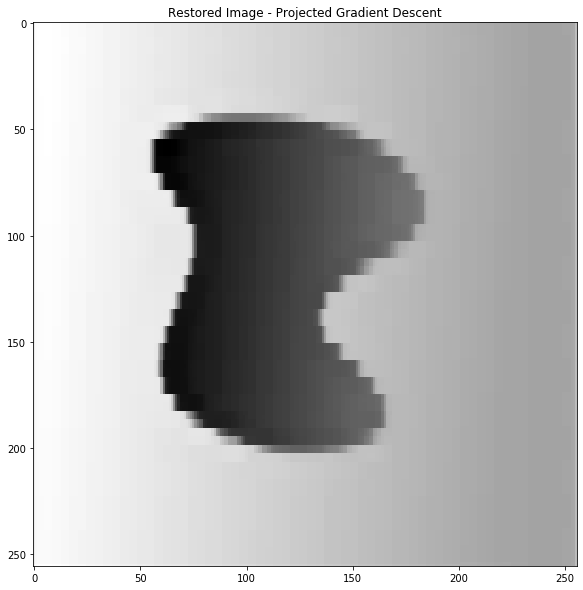

In [42]:
# reconstruction[np.isnan(reconstruction)] = 0
fig = plt.figure()
plt.imshow(reconstruction, cmap='gray'); plt.title("Restored Image - Projected Gradient Descent")
plt.show()

## Final Image Quality
Use the below method to calculate the psnr on your reconstruction and display the reconstruction.

In [40]:
print(np.max(reconstruction[:]))
print(utils.calculate_psnr(reconstruction, test_image))

236.29313906405912
27.111935445558796
